In [1]:
import os
import torch
import numpy as np
import Boone_Scatter
import matplotlib.pyplot as plt

import sys
sys.path.append('/n/home09/kboone/scattering_transform/')
sys.path.append('/n/home09/kboone/software/Cls_and_WST/')
import scattering
from patchify import *

use torch backend


In [2]:
nside = 1024
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios/maps_cmbl_georgios/'

In [3]:
all_files = np.array(os.listdir(conv_dir))
fid_inds = [i for i, s in enumerate(all_files) if s.startswith('f')]
fid_files = all_files[fid_inds]

In [4]:
Map = np.copy(np.load(conv_dir+fid_files[0], allow_pickle='True').item()['full_sky_noiseless'])

In [5]:
patch_inds = np.load('../Data/Patches/patches_nside_1024.npy')
coords = np.load('../Data/Patches/coords_nside_1024.npy')
unmask = patch_inds > -0.5

In [6]:
np.sqrt(len(patch_inds)/12)

8.0

In [7]:
patches = np.zeros_like(patch_inds).astype(float)
patches[unmask] = np.take(Map, patch_inds[unmask])

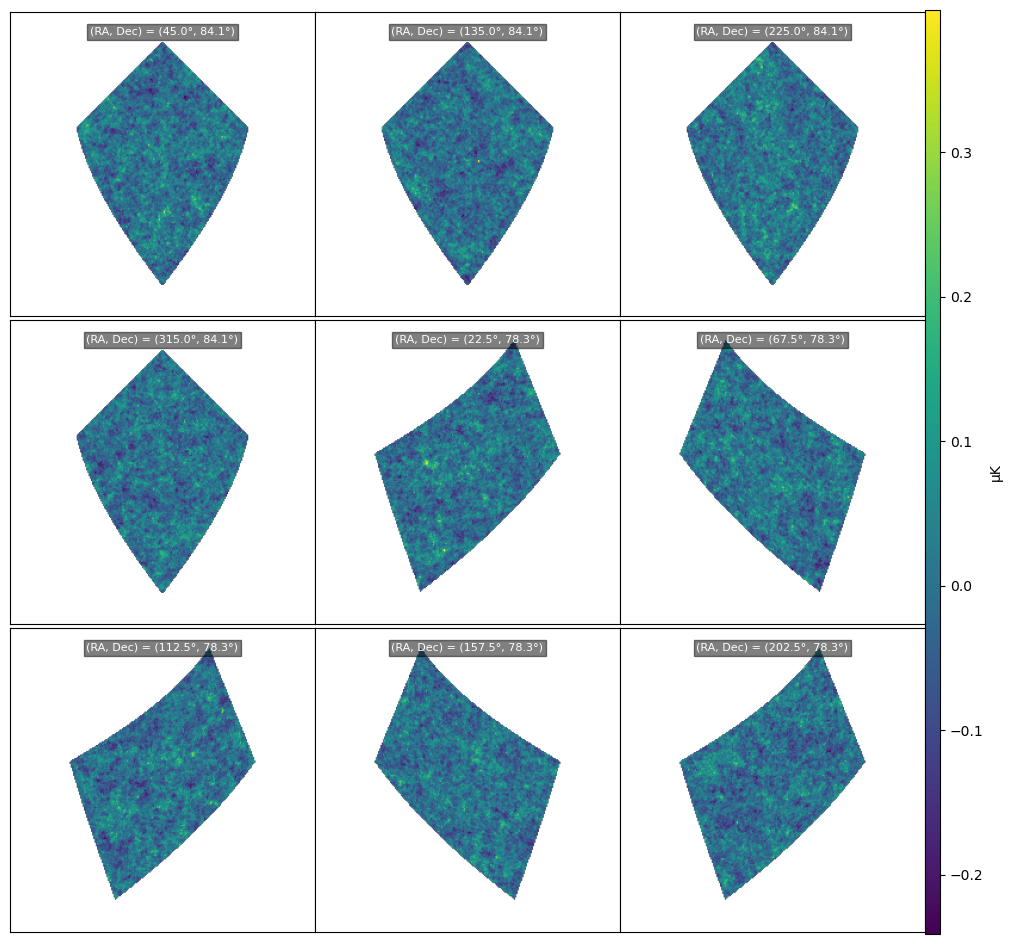

In [8]:
plot_patches(patches, coords, nrows=3, ncols=3, start_idx=0)

In [9]:
num = 10
imgs = patches[0:num]
J=7
L=4
numS = 50

In [10]:
st_calc = scattering.Scattering2d(M=256, N=256, J=6, L=L, device='cpu')

In [11]:
s_mean = st_calc.scattering_coef_simple(np.array([imgs[0]]))

In [12]:
s_mean['S1_iso']

tensor([[0.0034, 0.0033, 0.0030, 0.0025, 0.0020, 0.0016]], dtype=torch.float64)

In [23]:
bo_calc = Boone_Scatter.Lin_Scattering2d(M=256, N=256, numS=numS, L=L)

In [24]:
s_mean = bo_calc.scattering_coef_simple(np.array([imgs[0]]))

In [65]:
s = np.arange(numS) # This is essentially a measure of the scales used.

S1 = np.array(s_mean['S1_iso'])[0]
S2 = np.array(s_mean['S2_iso'])[0]

S1_stat = np.zeros_like(S1)
S2_stat = np.ones_like(S2)
for dl in np.arange(len(S2.T)):
    S2_stat[:,:,dl] += dl*np.ones_like(S2_stat[:,:,dl])
    
S1_scales = np.arange(numS)
    
S2_scales = np.zeros_like(S2)
for j1 in np.arange(len(S2)):
    for j2 in np.arange(len(S2[j1])):
        S2_scales[j1,j2] = (numS*j2 + j1) * np.ones_like(S2_scales[j1,j2])
        
S2 = S2.flatten()
S2_stat = S2_stat.flatten()
S2_scales = S2_scales.flatten()

crop = ~np.isnan(S2)

S2 = S2[crop]
S2_stat = S2_stat[crop]
S2_scales = S2_scales[crop]

total_vec = np.append(S1, S2)
summary_stat = np.append(S1_stat, S2_stat)
scales = np.append(S1_scales, S2_scales)
track_inds = np.arange(len(total_vec))
stat_sort = np.argsort(summary_stat)

scales = scales[stat_sort]
summary_stat = summary_stat[stat_sort]
track_inds = track_inds[stat_sort]

groups = [np.where(summary_stat==v)[0] for v in np.unique(summary_stat)]

for group in groups:
    scale_sort = np.argsort(scales[group])[::-1]
    scales[group] = scales[group][scale_sort]
    summary_stat[group] = summary_stat[group][scale_sort]
    track_inds[group] = track_inds[group][scale_sort]

In [73]:
_, counts = np.unique(summary_stat, return_counts=True)
x_pivots = (np.cumsum(counts)-0.5)[:-1]

In [76]:
# np.save('../Data/MCMC_Sorting/WST_S50_L4_Inds.npy', track_inds)
# np.save('../Data/MCMC_Sorting/WST_S50_L4_Pivots.npy', x_pivots)

In [78]:
np.load('../Data/MCMC_Sorting/WST_S50_L4_Pivots.npy')

array([  49.5, 1324.5, 2599.5, 3874.5])